# Load package

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

from sklearn.metrics import r2_score

The current HDDM version is:  0.9.8RC
The current kabuki version is:  0.6.5RC3
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.14.0


# Load data

In [2]:
cpath=os.getcwd()
lname=cpath+'/ior_stroop_alldata.csv'
data=pd.read_csv(lname)
data['rt']=data['rt']/1000
data.rename(columns={"sub_idx": "subj_idx"}, inplace=True)

# Run model 2

In [3]:
from IOR_stroop_model_utils import m2_id

In [4]:
nsample=10000
burns=2000
thins=2
chains = 4

In [ ]:
%%time

file_names = glob.glob("m2_id_tmp" + "_chain_*[!db]", recursive=False)

if file_names:
    file_names = sorted(file_names, key=lambda x: x[-1]) # sort filenames by chain ID
    m1res = []
    for fname in file_names:
        print('current loading: ', fname, '\n')
        m1res.append(hddm.load(fname))
else:
    m1res = p_map(partial(m2_id, df=data, samples=nsample, burn=burns, thin=thins,save_name="m2_id_tmp"), range(chains))

# 2.Load Model

In [6]:
file_names = glob.glob("m2_id_tmp" + "_chain_*[!db]", recursive=False)
m2=[]
for f in file_names:
    m2.append(hddm.load(f))

# 3.Model convergence

#### R-hat 指标检查模型是否拟合好了，所有参数的R-hat<1.01 则表明模型拟合好了

In [ ]:
from kabuki.analyze import gelman_rubin
gelman_rubin(m2)

In [8]:
np.max(list(gelman_rubin(m2).values()))

1.1414679041253741

#### combine these three models to get a better approximation of the posterior distribution.

In [9]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(m2)

### visual trace

In [ ]:
m.plot_posteriors(save=True)

In [10]:
m.dic

-21126.943542163284

# 4.Compute R^2

In [11]:
scsv=pd.DataFrame([m.values])
scsv.to_csv('iorstroop_m2_group_model_param.csv')

In [12]:
#modelt_1.csv
filename = 'iorstroop_m2_group_model_param.csv'
model_excel = pd.read_csv(filename)
#simulate data for group ourside
ename=['semantic_cue','semantic_uncue','response_cue','response_uncue','netural_cue','netural_uncue']
pname=['v','v_std','a','a_std','t','t_std']
params={}
for e in ename:
    params[e]={}
    for p in range(len(pname)):
        if p==0 or p==2 or p==4:
            this_name=pname[p]+'('+e+')'
        else:
            this_name=pname[p]  
        params[e][pname[p]]=model_excel[this_name][0]
        params[e]['z']=0.5

## false & real data

In [26]:
simulated = hddm.generate.gen_rand_data(params,size=10000)
simulated_data=simulated[0]

In [27]:
fdata,rdata={},{}
for e in ename:
    fdata[e]=simulated_data[simulated_data['condition']==e]
    rdata[e]=data[data['expconds']==e]

In [28]:
fdata_rt,rdata_rt={},{}
fdata_acc,rdata_acc={},{}
for e in ename:
    fdata_rt[e] = np.mean(fdata[e]['rt'])
    rdata_rt[e] = pd.DataFrame(rdata[e]['rt']).mean()
    fdata_acc[e]=float(np.sum(fdata[e]['response']==1))/len(fdata[e])
    rdata_acc[e]=float(np.sum(rdata[e]['response']==1))/len(rdata[e])

TypeError: only size-1 arrays can be converted to Python scalars

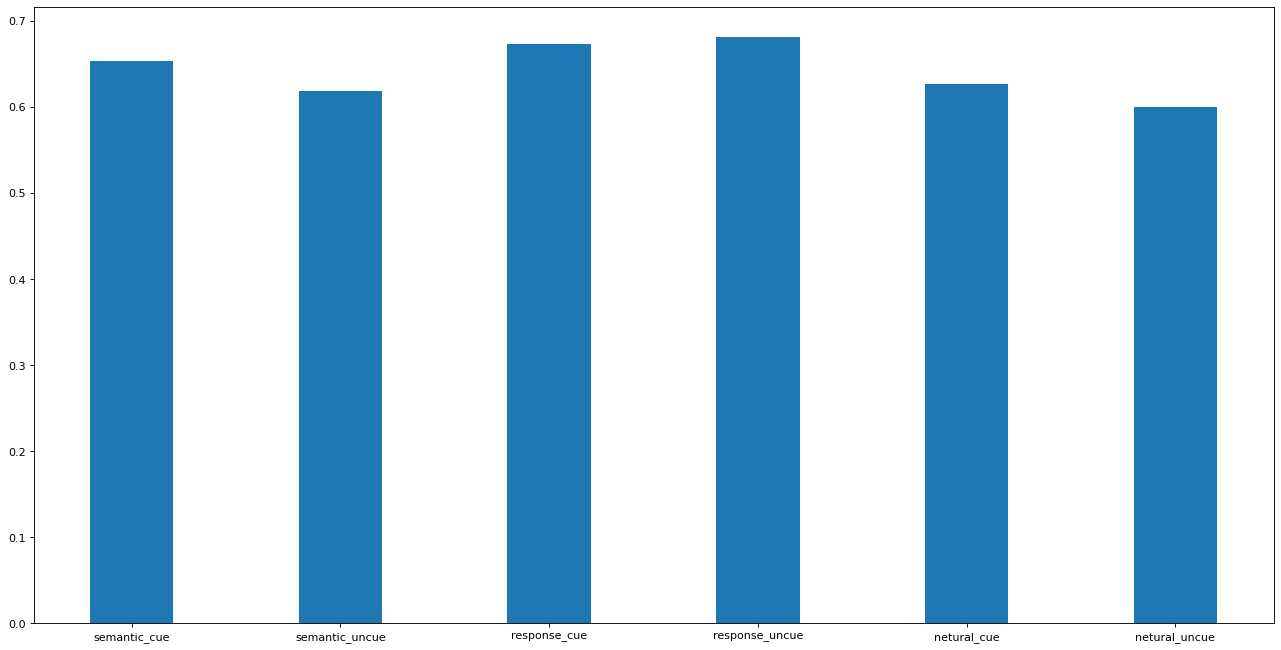

In [29]:
## plot data distribution

import numpy as np

fd_r,rd_r,fd_a,rd_a=[],[],[],[]
for e in ename:
    fd_r.append(fdata_rt[e])
    rd_r.append(rdata_rt[e])
    fd_a.append(fdata_acc[e])
    rd_a.append(rdata_acc[e])

## rt
fig,ax = plt.subplots(figsize=(20,10),dpi=80)
width_1 = 0.4
ax.bar(np.arange(len(fd_r)),fd_r,width=width_1,tick_label=ename,label = "false data")
ax.bar(np.arange(len(rd_r))+width_1,rd_r,width=width_1,tick_label=ename,label="real data")
ax.legend()
plt.ylabel('RT (ms)')
plt.show()

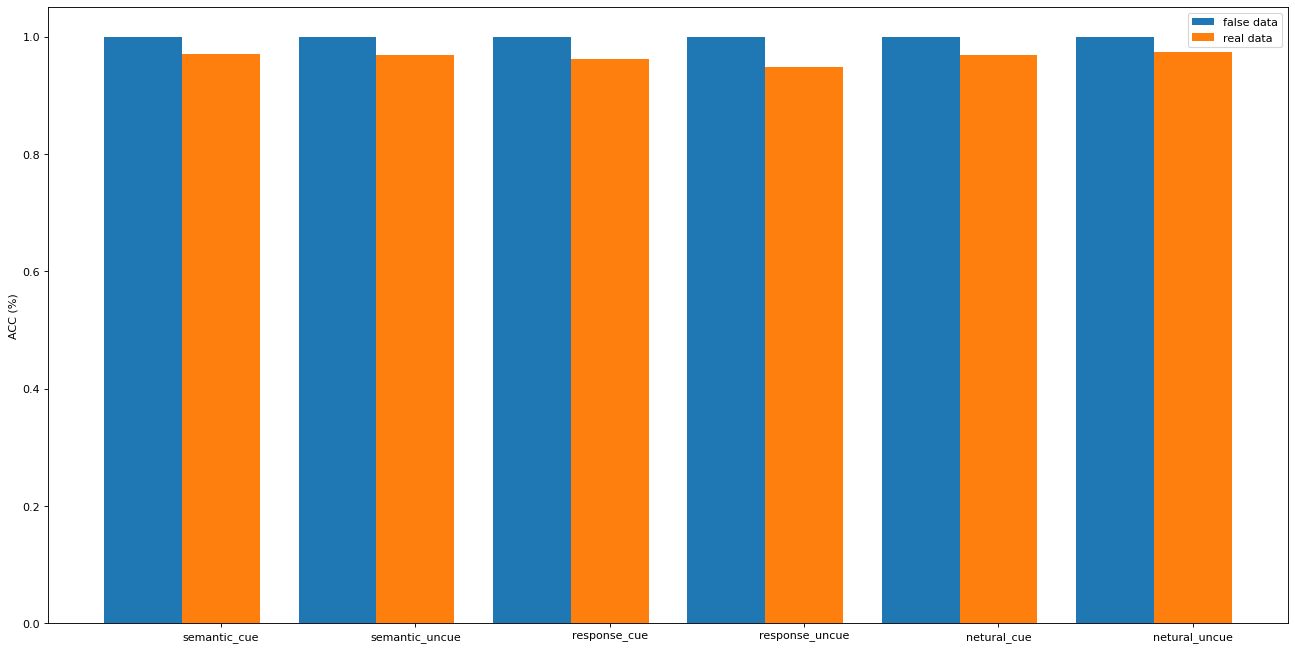

In [30]:
## acc
fig,ax = plt.subplots(figsize=(20,10),dpi=80)
width_1 = 0.4
ax.bar(np.arange(len(fd_a)),fd_a,width=width_1,tick_label=ename,label = "false data")
ax.bar(np.arange(len(rd_a))+width_1,rd_a,width=width_1,tick_label=ename,label="real data")
ax.legend()
plt.ylabel('ACC (%)')
plt.show()

In [31]:
print('r2_score rt:   ',  r2_score(np.array(rd_r), np.array(fd_r)))
print('r2_score acc:  ',  r2_score(np.array(rd_a), np.array(fd_a)))

r2_score rt:    -0.3521770142196661
r2_score acc:   -17.62382403380631
